# DATABASE & ANALYTICS PROGRAMMING

## Module 1

### Web Scraping Data 

In [1]:
# Web scraping and storing the file as CSV
def fetchRequiredCSV():
    """ 
    This function will scrape required content from web.
    Input: Input is static as we are scrapping only 1 fixed link to identify our required file.
    Output: Output will be csv file containing data of year 2020 stored locally.
    """
    import requests
    from bs4 import BeautifulSoup
    # Below brings all the content of given web page.
    response = requests.get('https://data.ehealthireland.ie/dataset/general-referrals-by-hospital-department-and-year')
    # html_soup will parse content of webpage in html format.
    html_soup = BeautifulSoup(response.content, features="html.parser")
    # Below allAnchorTags will fetch all anchor tags data in the form of list.
    allAnchorTags = html_soup.find_all('a')
    # I am now going to loop on each element of anchor tags list.
    for aTag in allAnchorTags:
        # Below will fetch content of href from each anchor tag.
        link = aTag.attrs['href']
        # Now, I am checking if my found link has .csv file or link to other page.
        # In case it is link to other page, I will simply ignore it.
        if link.find(".csv") != -1:
            # In case link is .csv file name, read csv file.
            file_stream = requests.get(link,stream=True)
            # Now, I will loop through all contents of csv file.
            for record in file_stream:
                # I will now decode csv data as it will be in byte stream encoded by utf8 format.
                data = record.decode('utf8', errors='ignore')
                # In case my data contains date with year 2020, it is required file.
                if data.find("-2020") != -1:
                    # I am storing file name to be used later on.
                    requiredFileName = link
                    break
    # I am opening a new file locally to write content of above identified file.
    with open('Hospital_data.csv', 'wb') as fileWritter:
        # Fetching all data using file stream.
        file_stream = requests.get(requiredFileName,stream=True)
        # Looping on each line of file.
        for record in file_stream.iter_content(chunk_size=1024 * 1024):
            # Writing content of file locally.
            fileWritter.write(record)

### Converting CSV to JSON 

In [2]:
def csvToJson():
    """ 
    This function will convert CSV data into JSON data.
    Input: Input is static CSV file which is web scrapped.
    Output: Output will be JSON file containing JSON data.
    """
    # Importing necessary libraries
    import csv
    import json
    # Opening CSV file which needs to be converted in read only mode.
    f = open('Hospital_data.csv', 'r')
    # Creating a CSV reader
    reader = csv.DictReader(f) 
    # Opening JSON file in write mode to write the data in it.
    with open('Hospital_data.json', 'w') as f:
        # Looping for all the record in CSV file
        for i in reader: 
            # Creating dump in json format
            json.dump(i,f)
            # Writing in JSON file
            f.write('\n')
    # Opening JSON file in read mode, reading line by line and storing JSON records in variable data
    json_data = [json.loads(line) for line in open('Hospital_data.json', 'r')]
    # Returning json data to store in MongoDB
    return json_data

### Storing JSON data in MongoDB and Retrieving

In [3]:
## Storing raw JSON data into MongoDB
def opnMongoDB(json_data):
    """ 
    This function will store JSON data into MongoDB and will fetch data from MongoDB into a dataframe.
    Input: Input is Json data which needs to be stored in database.
    Output: Output is dataframe having data retrieved from MongoDB.
    """
    # Importing necessary libraries
    from pymongo import MongoClient
    import pandas as pd
    # Making a Connection with MongoClient
    client = MongoClient('192.168.56.30', 27017)
    # Creating a client for MongoDB
    db = client['Client_DAPProj']
    # Creating a database in MongoDB
    hos_collection = db['Hospital_DB']
    # Deleting all old records from database if any exists before inserting new records.
    db.Hospital_DB.delete_many({ });
    # Inserting records into MongoDB
    result = hos_collection.insert_many(json_data)
    # Creating a cursor
    hospital_cursor = hos_collection.find()
    # Creating a datalist
    hospital_datalist = list(hospital_cursor)
    # Storing datalist as dataframe
    hospital_df = pd.DataFrame(hospital_datalist)
    # Returning data in dataframe
    return hospital_df

#### Functions required in Data cleaning

In [4]:
# Checking if any special character is present and excluding it.
def CheckString(GivenString):
    """ 
    This function will check if any special character is present and will exclude it if any.
    Input: Input is String or Pandas Dataframe columns which can be given as Pandas Series.
    Output: Output will be cleaned String with no special characters. 
    """
    # Initialising temp string.
    TempString = ""
    # Looping for length of given string.
    for i in GivenString:
        # assigning integer value of current character to variable.
        value = ord(i)
        # In case assigned character is a-z or A-Z or space, do as below.
        if(value == 32 or (value>64 and value<91) or (value>96 and value<123)):
            # Add current character to temperory memory. This will be finally returned once all characters of string are checked.
            TempString = TempString + i
    # Returning the cleaned string.
    return TempString 

In [5]:
# Function to convert Month column which has names of the month to numeric.
def month_to_num(month):
    """ 
    This function will convert string Month to numeric.
    Input: Input is string Month or Pandas Dataframe columns which can be given as Pandas Series.
    Output: Output will be numeric Month
    """
    # Creating a List of all months
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    # Returning Index of month + 1 which gives the exact numeric value for that month
    return months.index(month) + 1

### Data Cleaning

In [6]:
def dataCleaning(hospital_df):
    """ 
    This function will clean the input dataframe.
    Input: Input is a dataframe which needs to be cleaned.
    Output: Output will be cleaned dataframe.
    """
    # Separating Month_Year column
    hospital_df[['Month','Year']] = hospital_df.Month_Year.str.split("-", expand=True)
    # Separating Month_Year column
    hospital_df[['Month','Year']] = hospital_df.Month_Year.str.split("-", expand=True)
    # Dropping redundant columns
    hospital_df = hospital_df.drop(['_id','Month_Year','Hospital_ID','Year'], axis=1)
    # Replacing '\' char with blank space in Hospital_Department and Hospital Name columns
    hospital_df['Hospital_Department'] = hospital_df['Hospital_Department'].replace({'\'': ''}, regex=True)
    hospital_df['Hospital_Name'] = hospital_df['Hospital_Name'].replace({'\'': ''}, regex=True)
    # Applying the Check String function on all the columns of the dataframe having string values .
    hospital_df["Hospital_Department"] = hospital_df["Hospital_Department"].apply(CheckString) 
    hospital_df["Hospital_Name"] = hospital_df["Hospital_Name"].apply(CheckString) 
    hospital_df["ReferralType"] = hospital_df["ReferralType"].apply(CheckString)
    # Applying Month to number conversion function on Month column
    hospital_df["Month"] = hospital_df["Month"].apply(month_to_num) 
    # Resetting index in order to add Unique column in the dataframe
    hospital_df = hospital_df.reset_index()
    # Dropping extra index column
    hospital_df = hospital_df.drop(['index'], axis = 1)
    # Renaming index column as Unique Column
    hospital_df.index.rename('Unique_col', inplace=True)
    # Again resetting index to bring it in proper format
    hospital_df.reset_index(inplace=True)
    # Renaming Columns of the Hospital dataframe
    hospital_df.rename(columns = {'Hospital_Department': 'Hosp_Dept','ReferralType':'RefType','TotalReferrals':'TotalRef'}, 
                       inplace=True)
    # Converting the data type of Total Referral column to integer
    hospital_df['TotalRef'] = hospital_df['TotalRef'].astype('int64')
    # Storing Cleaned CSV file locally to store in POSTGRESQL database
    hospital_df.to_csv("HospitalRefData.csv", index=None)
    # Returning cleaned dataframe
    return hospital_df

### Storing Cleaned Data into PostgreSQL database.

In [7]:
## Connecting to Postgre database and Creating new database.
def createDB():
    """ 
    This function will connect to PostgreSQL database and will create new database.
    Input: Input is the SQL query to create database.
    Output: The database will be created in PostgreSQL
    """
    # Importing necessary libraries
    import psycopg2
    try:
        # Making a connection with PostgreSQL database
        dbConnection = psycopg2.connect(
            user = "dap",
            password = "dap",
            host = "192.168.56.30",
            port = "5432",
            database = "postgres")
        # Below statement is for autocommit
        dbConnection.set_isolation_level(0) 
        # Creating a DB cursor
        dbCursor = dbConnection.cursor()
        # Dropping database if already present
        dbCursor.execute("DROP DATABASE IF EXISTS DAPProject;")
        # Executing SQL statement using DB cursor
        dbCursor.execute('CREATE DATABASE DAPProject;')
        # Closing the DB cursor
        dbCursor.close()
    except (Exception , psycopg2.Error) as dbError :
        # Printing error if occurred while connecting to PostgreSQL database
        print ("Error while connecting to PostgreSQL", dbError)
    finally:
        # Finally close the DB connection
        if(dbConnection): dbConnection.close()

In [8]:
# Connecting and inserting records in Table created from Cleaned CSV file.
def insertData():
    """ 
    This function will connect to PostgreSQL database, create new table and insert values.
    Input: Input is the SQL query to create table and insert values.
    Output: The table will be created in PostgreSQL and values will be inserted.
    """
    # Importing necessary libraries
    import psycopg2
    import csv
    import os
    # Setting path of current working directory
    path = os.getcwd()
    # SQL statement to create table in database.
    createtblString = """
    CREATE TABLE Hospital_Table(
    Unique_col int PRIMARY KEY, 
    hospital_name varchar(255),
    hospital_dept varchar(255),
    reftype varchar(255),
    totalref int,
    month int
    );
    """
    try:
        # Making a connection with PostgreSQL database
        dbConnection = psycopg2.connect(
            user = "dap",
            password = "dap",
            host = "192.168.56.30",
            port = "5432",
            database = "dapproject")
        # Below statement is for autocommit
        dbConnection.set_isolation_level(0) 
        # Creating a DB cursor
        dbCursor = dbConnection.cursor()
        # Executing SQL statement using DB cursor, first dropping the table if already exists 
        dbCursor.execute("DROP TABLE IF EXISTS Hospital_Table;")
        # Executing SQL statement using DB cursor, creating table in database 
        dbCursor.execute(createtblString)
        # Inserting records in table
        insertStr = "INSERT INTO Hospital_Table VALUES ({}"+",'{}',"+"'{}',"+"'{}',"+"{},"+"{})"
        # Opening Cleaned CSV file in read mode
        with open(path + '\HospitalRefData.csv','r') as f:
            # Reading each record from CSV file using CSV reader
            reader = csv.reader(f)
            # skipping the header
            next(reader) 
            # For each record in CSV file 
            for row in reader:
                # Inserting record in table using DB cursor
                dbCursor.execute(insertStr.format(*row))
        # Commiting the transaction using DB connection        
        dbConnection.commit()
        # Closing the DB cursor
        dbCursor.close()
    except (Exception , psycopg2.Error) as dbError :
        # Printing error if occurred while connecting to PostgreSQL database
        print ("Error:", dbError)
    finally:
        # Finally close the DB connection
        if(dbConnection): dbConnection.close()

In [9]:
def opnPostgre():
    """ 
    This function will connect to PostgreSQL database, create new database, new table and insert values.
    Input: Input is the SQL query to create database, table and insert values.
    Output: The database and table will be created in PostgreSQL and values will be inserted.
    """
    # To create new database in postgreSQL.
    createDB()
    # To create new table and insert values in database.
    insertData()

### Data Visualization

In [10]:
## Fetching data from postgresql database and storing in dataframe for visualization
def dv12():
    """ 
    This function will connect to PostgreSQL database, perform sql operations and visualize data.
    Input: Input is the SQL query to get data in dataframe
    Output: Visualize data from dataframe
    """
    # Importing necessary libraries
    import matplotlib.pyplot as plt
    from plotly.offline import iplot
    import pandas.io.sql as sqlio
    import seaborn as sns
    import psycopg2
    # Creating SQL statement 
    sql1 = """ SELECT *  FROM Hospital_Table where reftype = 'Covid Testing Referral';"""
    try:
        # Making a connection with PostgreSQL database
        dbConnection = psycopg2.connect(
            user = "dap",
            password = "dap",
            host = "192.168.56.30",
            port = "5432",
            database = "dapproject")
        # Executing the created SQL statement using DB connection
        df1 = sqlio.read_sql_query(sql1, dbConnection)
    except (Exception , psycopg2.Error) as dbError :
        # Printing error if occurred while connecting to PostgreSQL database
        print ("Error:", dbError)
    finally:
        # Finally close the DB connection
        if(dbConnection): dbConnection.close()
    
    # Creating SQL statement 2
    sql2 = """ SELECT totalref, reftype FROM Hospital_Table;"""
    try:
        # Making a connection with PostgreSQL database
        dbConnection = psycopg2.connect(
            user = "dap",
            password = "dap",
            host = "192.168.56.30",
            port = "5432",
            database = "dapproject")
        # Executing the created SQL statement using DB connection
        df2 = sqlio.read_sql_query(sql2, dbConnection)
    except (Exception , psycopg2.Error) as dbError :
        # Printing error if occurred while connecting to PostgreSQL database
        print ("Error:", dbError)
    finally:
        # Finally close the DB connection
        if(dbConnection): dbConnection.close()      

    ## Data Visualization 1
    # Creating a barplot of Month and Total Referrals.
    sns.barplot(x="month", y="totalref", data=df1)
    # Labelling X-axis
    plt.xlabel("Month")
    # Labelling X-axis
    plt.ylabel("Total referrals in month")
    # Giving a title to the figure
    plt.title("Plot 1: Total Covid-19 referrals in a month")
    # To Display the figure
    plt.show()
    
    ## Data Visualization 2
    # Creating a pie chart for Referral Type
    fig1 = {
      "data": [{"values": list(df2.totalref), "labels": df2.reftype, "domain": {"x": [0, .5]}, "name": "TotalReferrals",
                "hoverinfo":"label+percent", "hole": .3, "type": "pie"}], 
                "layout": {"title":"Plot 2: Percentage of each Referral Type",
                "annotations": [{"font": {"size": 20}, "showarrow": False, "text": "Total Referrals", "x": 0.20, "y": 1}]}
    }
    # To display the figure
    iplot(fig1)

In [11]:
## Fetching data from postgresql database and storing in dataframe for visualization
def dv34(hospital_df):
    """ 
    This function will connect to PostgreSQL database, perform sql operations and visualize data.
    Input: Input is the SQL query to get data in dataframe
    Output: Visualize data from dataframe
    """
    # Importing necessary libraries
    from skimage import io
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    import pandas.io.sql as sqlio
    import plotly.express as px
    import psycopg2
    import os
    # Setting path of current working directory
    path = os.getcwd()
    # Creating SQL statement 
    sql = """ SELECT * FROM Hospital_Table where hospital_name='A Covid  Testing Service';"""
    try:
        # Making a connection with PostgreSQL database
        dbConnection = psycopg2.connect(
            user = "dap",
            password = "dap",
            host = "192.168.56.30",
            port = "5432",
            database = "dapproject")
        # Executing the created SQL statement using DB connection
        df3 = sqlio.read_sql_query(sql, dbConnection)
    except (Exception , psycopg2.Error) as dbError :
        # Printing error if occurred while connecting to PostgreSQL database
        print ("Error:", dbError)
    finally:
        # Finally close the DB connection
        if(dbConnection): dbConnection.close()
            #     url = "C:/Users/Prasad/Desktop/DAP/Project/corona.png"
    ## Data Visualization 3
    # Storing the path for corona mask image
    url = path + '\corona.png'
    # Reading the URL path and storing mask in mask variable
    mask = io.imread(url)
    # Generating wordcloud object
    wc_all_words=WordCloud(background_color="white", width=400, height=384, colormap='Dark2',
                           random_state=21, mask=mask,contour_width=1,max_font_size=200).generate(" ".join(df3.hospital_dept))
    # Plotting wordcloud
    plt.figure(figsize=(10,10)) # Specifying height and width for figure
    plt.imshow(wc_all_words, interpolation='bilinear') # To show the figure with the wordcloud object created 
    plt.title("Plot 3: Word cloud for Hospital Departments")
    plt.axis('off') # To turn off axes in plot
    plt.show() # To display the figure
    
    ## Data Visualization 4
    # Creating a scatter plot between Total Referrals and Hospital Department with Referral Type
    fig4 = px.scatter(hospital_df, x = 'TotalRef', y = 'Hosp_Dept', color = 'RefType', log_x=True, range_x=[10,4000], 
                     hover_name='Hospital_Name', animation_frame='Month', animation_group='Hosp_Dept')
    # Adding title to the figure and labelling x and y axis
    fig4.update_layout(title = 'Plot 4: Scatterplot of TotalReferrals and Hospital Department',
                      xaxis_title = 'Total Referrals', yaxis_title = 'Hospital Department')
    # To display the figure
    fig4.show()

In [12]:
def dataVisualization(hospital_df):
    """ 
    This function will connect to PostgreSQL database, perform sql operations and visualize data.
    Input: Input is the SQL query to get data in dataframe and cleaned dataframe
    Output: Visualize data from dataframe
    """
    # Perform Data visualization 1 and 2
    dv12()
    # Perform Data visualization 3 and 4
    dv34(hospital_df)

### Statistical Details of Dataset

In [13]:
def statisticalDetails(hospital_df):
    """ 
    This function is to check the statistical details like mean, quartile, etc.
    Input: Input is final cleaned dataframe.
    Output: Output will be statistical measures and Pearson's Correlation Coefficient between all numerical features.
    """
    # Dropping Unique values column as it is not required now
    hospital_df = hospital_df.drop(['Unique_col'], axis = 1)
    # Checking some statistical details such as mean, percentile, etc.
    print("Statistical details of Hospital dataset")
    print("------------------------------------------")
    print(hospital_df.describe())
    #Checking Pearson's correlation between Month and TotalReferrals.
    print("\n Pearson's Correlation Coefficient for all numerical features present in Hospital dataset")
    print("-----------------------------------------------------------------------------------------")
    print(hospital_df.corr()) 

### Preparing data for joining

In [14]:
def dataPrep(hospital_df):
    """ 
    This function is to prepare Hospital dataset as per the requirement for joining.
    Input: Input is final cleaned dataframe. 
    Output: Output will be dataframe ready to be joined.
    """
    # Creating a copy cleaned hospital dataframe
    hosp_df = hospital_df.copy()
    # Dropping redundant column
    hosp_df = hosp_df.drop(['Unique_col'], axis = 1)
    # Filtering Hospital name with COVID testing service as we are interested in these instances only.
    hosp_df = hosp_df.loc[hosp_df['Hospital_Name'] == 'A Covid  Testing Service']
    # Dropping Hospital Name column as it is not required now
    hosp_df = hosp_df.drop(['Hospital_Name'], axis=1)
    # Merging multiple hospital departments into few departments
    hosp_df['Hosp_Dept'] = hosp_df['Hosp_Dept'].replace(['j Healthcare Worker Unable To Travel',
                                               'k Close Contact of Cfirmed Case Unable To Travel',
                                               'l At Risk Group Unable To Travel',
                                               'm Hhold Contact At Risk Group Unable To Travel',
                                               'p Prison Staff Unable To Travel',
                                               'q Pregnant Woman Unable To Travel', 'Unfit to Travel',
                                               'oHhold contact of Hcare Worker Unable to Travel',
                                               'n General Covid  Test Unable to Travel',
                                               'f Unable to Attend Clinic'],'Unable to travel')
    hosp_df['Hosp_Dept'] = hosp_df['Hosp_Dept'].replace(['Essential Worker','a Healthcare Worker','h Prison Staff',
                                              'g Household contact of Healthcare Worker'],'Essential Individuals')
    hosp_df['Hosp_Dept'] = hosp_df['Hosp_Dept'].replace(['General Covid  Testing','Covid Testing Service',
                                  'e General Covid  Test'],'General Covid Test')
    hosp_df['Hosp_Dept'] = hosp_df['Hosp_Dept'].replace(['i Pregnant Woman','Residential Setting','Prison Inmate'],'Others')
    hosp_df['Hosp_Dept'] = hosp_df['Hosp_Dept'].replace(['c At Risk Group','f Household Contact of At Risk Group',
                                               'b Close Contact of Confirmed Case'],'Risk Group Individuals')
    # Grouping by Hospital Department, Referral Type, Month, taking sum of total referrals and sorting values by Month
    hosp_df = hosp_df.groupby(['Hosp_Dept','RefType','Month']).agg({'TotalRef': 'sum'}).sort_values(by=['Month']).reset_index()
    # Saving final cleaned dataframe in CSV file for merging.
    hosp_df.to_csv('CleanedHospitalData.csv', index=None)

### Main function of the program

In [15]:
def mainExecute():
    """ 
    This is the main function from where the execution of program starts.
    Input: Input is CSV file which is web scraped.
    Output: Output will be analysis and visulizations performed on cleaned dataframe.
    """
    fetchRequiredCSV()
    jdata = csvToJson()
    hos_df = opnMongoDB(jdata)
    clean_df = dataCleaning(hos_df)
    opnPostgre()
    dataVisualization(clean_df)
    statisticalDetails(clean_df)
    dataPrep(clean_df)

In [17]:
pip install wordcloud

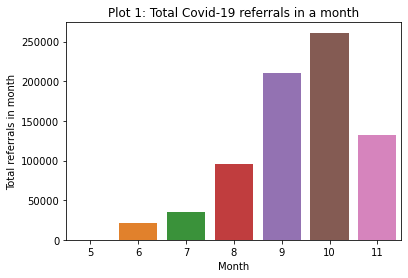

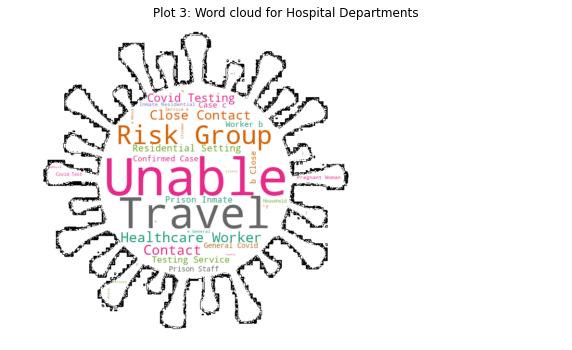

Statistical details of Hospital dataset
------------------------------------------
            TotalRef         Month
count   12997.000000  12997.000000
mean      138.336001      6.125567
std      3482.246944      3.175403
min         1.000000      1.000000
25%         8.000000      3.000000
50%        27.000000      6.000000
75%        70.000000      9.000000
max    261250.000000     11.000000

 Pearson's Correlation Coefficient for all numerical features present in Hospital dataset
-----------------------------------------------------------------------------------------
          TotalRef     Month
TotalRef  1.000000  0.017398
Month     0.017398  1.000000


In [18]:
# Calling the main function. This is point from where the execution of this program starts.
mainExecute()

💡 Insights: 
- Plot 1: We can see that in the month of October there were maximum Covid Testing Referrals done followed by September and November. Also we can notice that this type of referral was started from June 2020 only before that there were no referrals done of this type.
- Plot 2: We can infer that 53.5% of the total referrals were made under General Referral Category followed by 42.1% of Covid Testing Referrals. The Breast Clinic Referral was third with 2.21% of referrals which is also very low as compared to the first two.
- Plot 3: We can see the words like Risk Group, Travel, Healthcare Worker, Covid Testing, Close Contact and so on. These words are related to COVID-19. These were the main departments under 'A Covid Testing Service' hospital.
- Plot 4: We can infer that maximum patients come under General Referrals category followed by Covid Testing Referrals irrespective of hospital departments.

## Module 2

### Extracting file from webpage by Webscraping

In [19]:
# Author - Prasad Rudrappa Shivu (Student Id: 19213077)
# COVID-19 Dataset
#Webscraping the data file

#Import urllib library to webscrape
from urllib.request import urlretrieve as retrieve

#Assign URL of the online data to an object
url='https://opendata-geohive.hub.arcgis.com/datasets/d9be85b30d7748b5b7c09450b8aede63_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'

#Retrieve the file from the URL
retrieve(url,'Covid19CountyStatisticsHPSCIreland.csv')

('Covid19CountyStatisticsHPSCIreland.csv',
 <http.client.HTTPMessage at 0x19d1ca56bb0>)

### Convert CSV to JSON

In [20]:
# Convert the csv file to json

#Import the libraries required - json and csv
import csv 
import json 

#function to convert csv to json
def csv_to_json(csvFilePath, jsonFilePath):
    jsonArray = []

#read csv file
    with open(csvFilePath, encoding='utf-8') as csvf:

#load csv file data using csv library's dictionary reader
        csvReader = csv.DictReader(csvf)

#convert each csv row into python dict
        for row in csvReader:

#add this python dict to json array
            jsonArray.append(row)
    
#convert python jsonArray to JSON String and write to file
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf: 
        jsonString = json.dumps(jsonArray, indent=4)
        jsonf.write(jsonString)
          
#provide filenames to the parameters
csvFilePath = r'Covid19CountyStatisticsHPSCIreland.csv'
jsonFilePath = r'Covid19CountyStatisticsHPSCIreland.json'            

#call the function
csv_to_json(csvFilePath, jsonFilePath)       

### Load JSON file to an object

In [21]:
import json
#Assign the json file to an object
jobj1 = open(r"Covid19CountyStatisticsHPSCIreland.json")

#Load the json data
jdata1 = json.load(jobj1)

#display the file contents
jdata1

[{'\ufeffOBJECTID': '1',
  'ORIGID': '1',
  'CountyName': 'Carlow',
  'PopulationCensus16': '56932',
  'TimeStamp': '2020/02/27 00:00:00+00',
  'IGEasting': '278661',
  'IGNorthing': '163444',
  'Lat': '52.7168',
  'Long': '-6.8367',
  'UGI': 'http://data.geohive.ie/resource/county/2ae19629-143d-13a3-e055-000000000001',
  'ConfirmedCovidCases': '0',
  'PopulationProportionCovidCases': '',
  'ConfirmedCovidDeaths': '',
  'ConfirmedCovidRecovered': '',
  'Shape__Area': '2432351721.08691',
  'Shape__Length': '319348.572538664'},
 {'\ufeffOBJECTID': '2',
  'ORIGID': '2',
  'CountyName': 'Cavan',
  'PopulationCensus16': '76176',
  'TimeStamp': '2020/02/27 00:00:00+00',
  'IGEasting': '246380',
  'IGNorthing': '304501',
  'Lat': '53.9878',
  'Long': '-7.2937',
  'UGI': 'http://data.geohive.ie/resource/county/2ae19629-1448-13a3-e055-000000000001',
  'ConfirmedCovidCases': '0',
  'PopulationProportionCovidCases': '',
  'ConfirmedCovidDeaths': '',
  'ConfirmedCovidRecovered': '',
  'Shape__Area

### Load data to MongoDB

In [22]:
#importing pymongo
from pymongo import MongoClient
import pymongo as pym

In [23]:
#connect to mongodb
client = MongoClient('192.168.56.30', 27017)

#creating client for mongodb
db = client['DAPPro']

#creating db in mongodb
cov_collection = db['CovidDB']

db.CovidDB.delete_many({ });

In [24]:
#inserting records into DB
result = cov_collection.insert_many(jdata1)

### Load the data into Pandas Dataframe

In [25]:
#import pandas library
import pandas as pd

#find records in db
cov_cursor = cov_collection.find()

#creating list of records using cursor
cov_datalist = list(cov_cursor)

#store list in dataframe
cov_df = pd.DataFrame(cov_datalist)

In [26]:
#print the first five rows of the dataframe
cov_df.head()
#print the shape of the dataframe
cov_df.shape

(6500, 17)

### Data Cleaning - replace null with 0, remove unrequired colums and insert new columns

In [27]:
#drop the unrequired columns
cov_df = cov_df.drop(['_id','IGEasting','ORIGID','IGNorthing','UGI','ConfirmedCovidDeaths','ConfirmedCovidRecovered','Shape__Area','Shape__Length'],axis=1)

In [28]:
#fill null values with NaN

#import numpy library
import numpy as np

#replace empty spaces with NaN
cov_df=cov_df.replace("",np.NaN)

# here we are searching for white spaces and replacing it with NaN by the help of numpy
cov_df.isnull().sum()

﻿OBJECTID                           0
CountyName                          0
PopulationCensus16                  0
TimeStamp                           0
Lat                                 0
Long                                0
ConfirmedCovidCases                 0
PopulationProportionCovidCases    546
dtype: int64

In [29]:
#fill NaN places with 0
cov_df=cov_df.fillna(0)
#display first five rows of the dataframe
cov_df.head()

﻿OBJECTID CountyName PopulationCensus16               TimeStamp      Lat  \
0         1     Carlow              56932  2020/02/27 00:00:00+00  52.7168   
1         2      Cavan              76176  2020/02/27 00:00:00+00  53.9878   
2         3      Clare             118817  2020/02/27 00:00:00+00  52.8917   
3         4       Cork             542868  2020/02/27 00:00:00+00  51.9517   
4         5    Donegal             159192  2020/02/27 00:00:00+00  54.8989   

      Long ConfirmedCovidCases PopulationProportionCovidCases  
0  -6.8367                   0                              0  
1  -7.2937                   0                              0  
2  -8.9889                   0                              0  
3  -8.6372                   0                              0  
4    -7.96                   0                              0

In [30]:
#create a new 'date' column by separating date from timestamp as time values are 0 throughout
cov_df['Date'] = cov_df['TimeStamp'].str[:10]
#extract month from the date column
cov_df['Month'] = pd.DatetimeIndex(cov_df['Date']).month
#drop the column timestamp
del cov_df['TimeStamp']

In [31]:
#display first five rows of the dataframe
cov_df.head()
cov_df.shape

(6500, 9)

### Connect to postgreSQL, and Load data

In [32]:
#load the data in cov_df dataframe to new CSV file
cov_df.to_csv('CleanedCovidData.csv',index=None)

In [33]:
#connect to PostgreSQL and create empty database, coviddata

#import library
import psycopg2

try:
    #establish connecting by giving user, password, host IP, and DB name
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "postgres")
    
    #set isolation level to 0 / autocommit
    dbConnection.set_isolation_level(0)
    
    #establish cursor connection
    dbCursor = dbConnection.cursor()
    dbCursor.execute("DROP DATABASE IF EXISTS covidData1;")
    #create datbase
    dbCursor.execute("CREATE DATABASE covidData1;")
    
    #close the cursor
    dbCursor.close()

#throw except if connection is not established
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)

#close the connection
finally:
    if(dbConnection): dbConnection.close()

In [34]:
#create table in database
createString = """
CREATE TABLE covidtablenew(
OBJECTID integer,
CountyName varchar(255),
PopulationCensus16 numeric(15,1),
Lat float,
Long float,
ConfirmedCovidCases numeric(15,1),
PopulationProportionCovidCases float,
Date varchar(50),
Month integer
);
"""

try:
    #establish connecting by giving user, password, host IP, and DB name
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "coviddata1")
    
    #set isolation level to 0 / autocommit
    dbConnection.set_isolation_level(0)
    
    #establish cursor connection
    dbCursor = dbConnection.cursor()
    
    #drop the table if preexists
    dbCursor.execute("DROP TABLE IF EXISTS covidtablenew")
    
    #execute the create table query
    dbCursor.execute(createString)
    
    #close the cursor
    dbCursor.close()
    
#throw except if connection is not established
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)

#close the connection    
finally:
    if(dbConnection): dbConnection.close()

In [35]:
try:
    #establish connecting by giving user, password, host IP, and DB name
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "coviddata1")
    #set isolation level to 0 / autocommit
    dbConnection.set_isolation_level(0)
    #establish cursor connection
    dbCursor = dbConnection.cursor()
    #insert values into the table
    insertString = "INSERT INTO covidtablenew VALUES ({},"+"'{}',"+"{},"+"{},"+"{},"+"{},"+"{},"+"'{}',"+"{})"
    #use csv reader to read the read the values
    with open('CleanedCovidData.csv', 'r') as f:
        reader = csv.reader(f)
        # skip the header
        next(reader)
        #loop DB cursor to insert all values
        for row in reader:
            dbCursor.execute(insertString.format(*row)) 
    #close the cursor
    dbCursor.close()
#throw except if connection is not established
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
#close the connection
finally:
    if(dbConnection): dbConnection.close()

In [36]:
#import libraries
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2


#query to display the values grouped by Month
sql="""SELECT SUM(PopulationCensus16) as Population, SUM(confirmedcovidcases) as Confirmed_Cases,SUM(populationproportioncovidcases) as Population_Proportion_Covid_Cases,Month
       FROM covidtablenew
       GROUP BY Month;"""
try:
    #establish connecting by giving user, password, host IP, and DB name
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "coviddata1")
    
    #read and execute SQL query
    cov_df_dataframe1 = sqlio.read_sql_query(sql, dbConnection)  


#throw except if connection is not established
except (Exception , psycopg2.Error) as dbError :
    print ("Error", dbError)

#close the connection
finally:
    if(dbConnection): dbConnection.close()
cov_df_dataframe1.head()

population  confirmed_cases  population_proportion_covid_cases  month
0  147617815.0          21534.0                        7250.101689      3
1   19047460.0         253258.0                      125451.994656     11
2  147617815.0         850547.0                      397130.481951      8
3  147617815.0        1520707.0                      730996.916731     10
4  142855950.0         965681.0                      444532.046909      9

In [37]:
#import libraries
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2

#query to display the values grouped by CountyName
sql="""SELECT SUM(PopulationCensus16) as Population, SUM(confirmedcovidcases) as Confirmed_Cases,SUM(populationproportioncovidcases) as Population_Proportion_Covid_Cases, CountyName
       FROM covidtablenew
       GROUP BY CountyName;"""
try:
    #establish connecting by giving user, password, host IP, and DB name
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "coviddata1")
    
    #read and execute SQL query
    cov_df_dataframe2 = sqlio.read_sql_query(sql, dbConnection)  

#throw except if connection is not established
except (Exception , psycopg2.Error) as dbError :
    print ("Error", dbError)

#close the connection
finally:
    if(dbConnection): dbConnection.close()
cov_df_dataframe2.head()

population  confirmed_cases  population_proportion_covid_cases countyname
0  35606250.0         161519.0                      113406.354222    Wicklow
1  16136000.0          77030.0                      119344.942985  Roscommon
2  19490250.0         118098.0                      151483.434025     Offaly
3  32221000.0         183017.0                      142001.334533      Louth
4  48724750.0         166590.0                       85475.040919   Limerick

### Visualizations using matplotlib, seaborn and plotly

Text(0.5, 0, 'Months ')

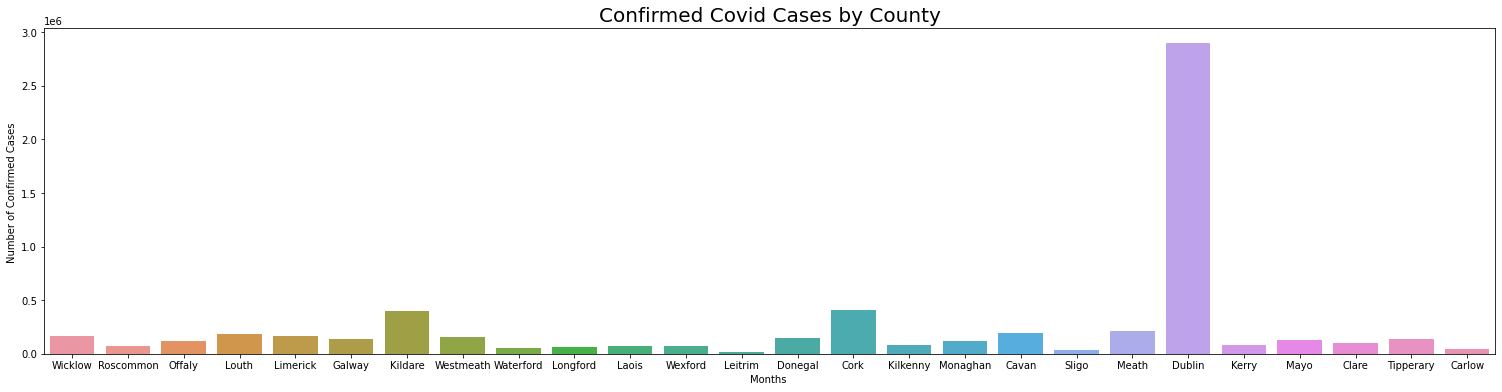

In [38]:
#importing visualization libraries seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
#set the size of the plot
plt.figure(figsize=(26, 6))
#bar plot
sns.barplot(x = cov_df_dataframe2['countyname'], y = cov_df_dataframe2['confirmed_cases'])
#plot title
plt.title('Confirmed Covid Cases by County', fontsize=20)
#Y-label
plt.ylabel('Number of Confirmed Cases ')
#X-label
plt.xlabel('Months ')

In [39]:
#Visualization using Plotly

#import plotly subplots
import plotly.graph_objs as go
from plotly.subplots import make_subplots

#assign dataframe values to object
covdata = cov_df_dataframe1

#define the number and placement of subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Monthly Population", "Monthly Confirmed Cases"))
#subplot 1
fig.add_trace(go.Scatter(x=covdata.index, y=covdata.population,mode="lines",name="population"),row=1, col=1)
#subplot 2
fig.add_trace(go.Scatter(x=covdata.index, y=covdata.confirmed_cases,mode="lines",name="confirmed_cases"),row=1, col=2)
#show plot
fig.show()

In [40]:
#bar plot shows the confirmed monthly covid cases
fig = go.Figure(data=[go.Bar(x=cov_df_dataframe1['month'], y=cov_df_dataframe1['population_proportion_covid_cases'], marker_color=['darkblue','blue','blueviolet','lightblue','indigo','yellowgreen','grey','orange','limegreen','olive','lightyellow'])])
#title of plot
fig.update_layout(title_text="Population Proportion Covid Cases by Month")
#display plot
fig.show()

## Module 3

In [41]:
import requests
import json
import pymongo
import os, glob
import pandas as pd
import csv
from pymongo import MongoClient
import pymongo as pym
import numpy as np
import seaborn as sns
import datetime
import psycopg2
import plotly.offline as po
import plotly.graph_objs as go

In [42]:
from urllib.request import urlretrieve as retrieve
url_common = 'https://data.smartdublin.ie/dataset/5cb924bb-b0b1-44c3-a51a-7144bebdd52c/resource/'
url_month10 = url_common + '43f8bc7a-a717-4df0-9f94-569b55f8d430/download/dcc-summary-tonnages-01.10-to-31.10.20csv.csv'
retrieve(url_month10,'Data10.csv')

url_month9 = url_common + 'e437075a-fb91-476d-aef9-d923ada5d550/download/dcc-summary-tonnages-01.09-to-30.09.20csv.csv'
retrieve(url_month9,'Data9.csv')

url_month8 = url_common + '8acec3b0-2fb5-450c-b177-6cc1bb235090/download/dcc-summary-tonnages-01.08-to-31.08.20csv.csv'
retrieve(url_month8,'Data8.csv')

url_month7 = url_common + 'ccb3d773-3876-4eac-8fe9-c32fb1e31e0d/download/dcc-summary-tonnages-01.07-to-31.07.20csv.csv'
retrieve(url_month7,'Data7.csv')

url_month6 = url_common + '71b11b9d-a8e7-4058-a0e7-70408e30a05b/download/dcc-summary-tonnages-01.06-to-30.06.20csv.csv'
retrieve(url_month6,'Data6.csv')

url_month5 = url_common + '9fe542ff-8d4f-4fb8-9609-da4cfa776876/download/dcc-summary-tonnages-01.05-to-31.05.20csv.csv'
retrieve(url_month5,'Data5.csv')

url_month4 = url_common + '18db26b7-76da-4a6f-95ee-1e2c4d9eb987/download/dcc-summary-tonnages-01.04-to-30.04.20csv.csv'
retrieve(url_month4,'Data4.csv')

url_month3 = url_common + '24459cec-4e03-4051-96ae-462365829edb/download/dcc-summary-tonnages-01.03-to-31.03.20csv.csv'
retrieve(url_month3,'Data3.csv')

url_month2 = url_common + 'afc75f33-d826-4101-a997-442f10a19932/download/dcc-summary-tonnages-01.02-to-29.02.20csv.csv'
retrieve(url_month2,'Data2.csv')

url_month1 = url_common + '69c3a108-73cb-4707-bd7a-1625c4e7c259/download/dcc-summary-tonnages-01.01-to-31.01.20csv.csv'
retrieve(url_month1,'Data1.csv')

('Data1.csv', <http.client.HTTPMessage at 0x19d1d4b5880>)

In [43]:
import os
path = os.getcwd()
files = glob.glob(os.path.join(path, "Data*.csv"))

In [44]:
each_file = (pd.read_csv(i, sep=',') for i in files)
merged_df = pd.concat(each_file, ignore_index=True)
merged_df.to_csv("Finalfile.csv", index=None)

In [45]:
merged_df.head()
merged_df.shape

(8106, 26)

In [46]:
with open("Finalfile.csv","r") as f:
    reader= csv.reader(f)
    next(reader)
    final_data=[]
    for row in reader:
        final_data.append({"Ticket No":row[0],"Address Name":row[1],"Date":row[2],"Product":row[3],"Qty":row[4],"Tare Weight":row[5],"Gross Weight":row[6],"Net Weight":row[7]})

In [47]:
with open("Finalfile.json","w") as f:
    json.dump(final_data, f, indent=4)

In [48]:
final_data

[{'Ticket No': '440310.0',
  'Address Name': 'STREET CLEANING (LEVY EXEMPT)',
  'Date': '31/01/2020 11:27',
  'Product': 'Street Cleaning Residues',
  'Qty': '2.84',
  'Tare Weight': '17280.0',
  'Gross Weight': '20120.0',
  'Net Weight': '2840.0'},
 {'Ticket No': '440019.0',
  'Address Name': 'STREET CLEANING (LEVY EXEMPT)',
  'Date': '31/01/2020 08:04',
  'Product': 'Street Cleaning Residues',
  'Qty': '0.66',
  'Tare Weight': '3800.0',
  'Gross Weight': '4460.0',
  'Net Weight': '660.0'},
 {'Ticket No': '440002.0',
  'Address Name': 'STREET CLEANING (LEVY EXEMPT)',
  'Date': '31/01/2020 07:35',
  'Product': 'Street Cleaning Residues',
  'Qty': '3.34',
  'Tare Weight': '17360.0',
  'Gross Weight': '20700.0',
  'Net Weight': '3340.0'},
 {'Ticket No': '439986.0',
  'Address Name': 'STREET CLEANING (LEVY EXEMPT)',
  'Date': '31/01/2020 07:08',
  'Product': 'Street Cleaning Residues',
  'Qty': '5.98',
  'Tare Weight': '17140.0',
  'Gross Weight': '23120.0',
  'Net Weight': '5980.0'},
 {'

In [49]:
client = MongoClient('192.168.56.30', 27017)
db = client['WastDAP']
waste_collection = db['Waste_DB']
db.Waste_DB.delete_many({ });
result = waste_collection.insert_many(final_data)

In [50]:
waste_cursor = waste_collection.find()
waste_datalist = list(waste_cursor)
waste_df = pd.DataFrame(waste_datalist)

In [51]:
waste_df.head()

_id Ticket No                   Address Name  \
0  6001a43aa0f6cd0e2ef87787  440310.0  STREET CLEANING (LEVY EXEMPT)   
1  6001a43aa0f6cd0e2ef87788  440019.0  STREET CLEANING (LEVY EXEMPT)   
2  6001a43aa0f6cd0e2ef87789  440002.0  STREET CLEANING (LEVY EXEMPT)   
3  6001a43aa0f6cd0e2ef8778a  439986.0  STREET CLEANING (LEVY EXEMPT)   
4  6001a43aa0f6cd0e2ef8778b  439981.0  STREET CLEANING (LEVY EXEMPT)   

               Date                   Product   Qty Tare Weight Gross Weight  \
0  31/01/2020 11:27  Street Cleaning Residues  2.84     17280.0      20120.0   
1  31/01/2020 08:04  Street Cleaning Residues  0.66      3800.0       4460.0   
2  31/01/2020 07:35  Street Cleaning Residues  3.34     17360.0      20700.0   
3  31/01/2020 07:08  Street Cleaning Residues  5.98     17140.0      23120.0   
4  31/01/2020 06:54  Street Cleaning Residues  6.06     17280.0      23340.0   

  Net Weight  
0     2840.0  
1      660.0  
2     3340.0  
3     5980.0  
4     6060.0

In [52]:
waste_df.isnull().sum()# to check is there any null value present value in our data set

_id             0
Ticket No       0
Address Name    0
Date            0
Product         0
Qty             0
Tare Weight     0
Gross Weight    0
Net Weight      0
dtype: int64

In [53]:
waste_df.isnull().any()#To check weather is there any empty values or not

_id             False
Ticket No       False
Address Name    False
Date            False
Product         False
Qty             False
Tare Weight     False
Gross Weight    False
Net Weight      False
dtype: bool

In [54]:
#step 2learn how to remove na values
waste_df = waste_df.dropna(how = "all")#it will drop row if all the row have NA values 

In [55]:
waste_df = waste_df.fillna(method = 'bfill')#this will copy below coloumn data

In [56]:
waste_df.drop('_id',axis=1,inplace=True)

In [57]:
waste_df['Date'] = pd.to_datetime(waste_df['Date'])
waste_df['OnlyDate'] = waste_df['Date'].dt.date

In [58]:
waste_df.drop(['Date'], axis=1, inplace=True)

In [59]:
waste_df.rename(columns = {'OnlyDate': 'Date'}, inplace = True)

In [60]:
import datetime
waste_df['Date'] = pd.to_datetime(waste_df['Date'])
waste_df['Month'] = waste_df['Date'].dt.month

In [61]:
waste_df.to_csv('CleanedGarbageData.csv', index = None)

In [62]:
try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "192.168.56.30",
    port = "5432",
    database = "postgres")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute("DROP DATABASE IF EXISTS Garbage2;")
    dbCursor.execute('CREATE DATABASE Garbage2;')
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [63]:
createString = """
CREATE TABLE GarbageData(
Ticket_No integer PRIMARY KEY,
Address varchar(255),
Product varchar(255),
Qty numeric(10,1),
Tare_Weight numeric(10,1),
Gross_Weight numeric(10,1),
Net_Weight numeric(10,1),
Date timestamp,
Month numeric(10,1)
);
"""
try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "192.168.56.30",
    port = "5432",
    database = "garbage2")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute("DROP TABLE IF EXISTS GarbageData")
    dbCursor.execute(createString)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [64]:
import os
path = os.getcwd()
try:
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "garbage2")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    insertString = "INSERT INTO GarbageData VALUES ({},"+"'{}',"+"'{}',"+"{},"+"{},"+"{},"+"{},"+"'{}',"+"{})"
    with open(path + '\CleanedGarbageData.csv','r') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        for row in reader:
            dbCursor.execute(insertString.format(*row))
    dbConnection.commit()
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

Error: syntax error at or near ","
LINE 1: INSERT INTO GarbageData VALUES (,'','',,,,,'',)
                                        ^



In [65]:
import pandas.io.sql as sqlio
query = """ SELECT *  FROM GarbageData where month =10;"""
try:
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "garbage2")
    dataframe2 = sqlio.read_sql_query(query, dbConnection)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

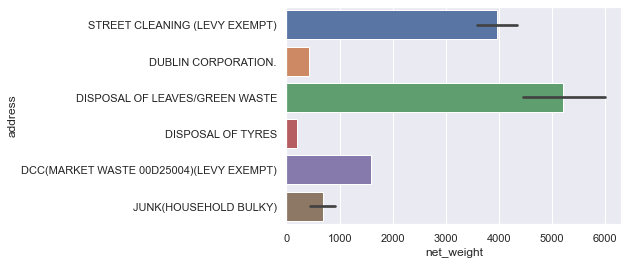

In [66]:
import seaborn as sns
sns.set(color_codes=True)
sns.barplot(dataframe2['net_weight'],dataframe2['address'])

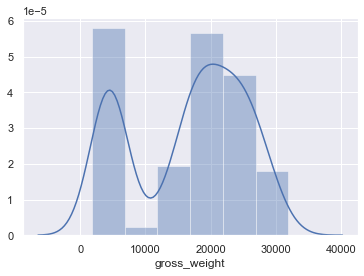

In [67]:
sns.distplot(dataframe2['gross_weight'])

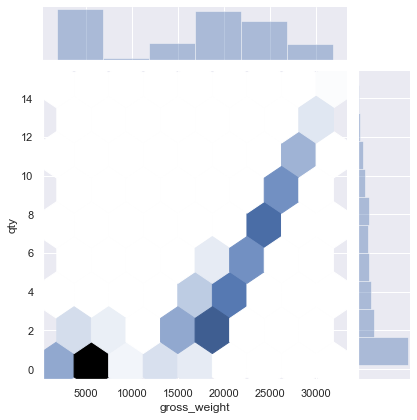

In [68]:
sns.jointplot(dataframe2['gross_weight'],dataframe2['qty'],kind="hex")

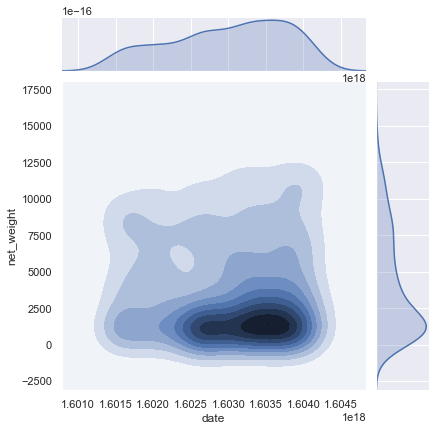

In [69]:
sns.jointplot(dataframe2['date'],dataframe2['net_weight'],kind="kde")

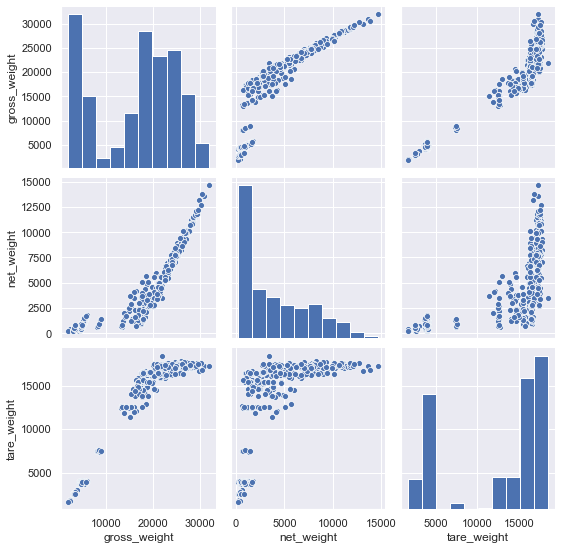

In [70]:
sns.pairplot(dataframe2[['gross_weight','net_weight','tare_weight']])

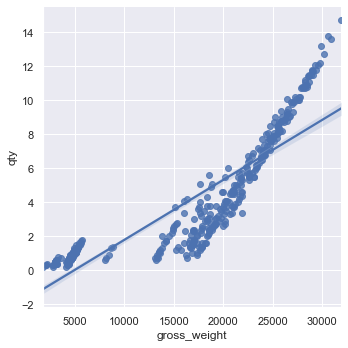

In [71]:
sns.lmplot(x='gross_weight',y='qty', data= dataframe2)

## Module 4

In [72]:
from bs4 import BeautifulSoup as bs #WebScaraping
import requests
from urllib.request import urlretrieve as retrieve
url='https://cli.fusio.net/cli/climate_data/webdata/dly3723.csv'
retrieve (url, 'weather.csv')

('weather.csv', <http.client.HTTPMessage at 0x19d2116dee0>)

In [73]:
import json
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [74]:
weather_df = pd.read_csv("weather.csv", skiprows=24)
weather_df.to_csv("weather1.csv", index=None)

In [75]:
with open("weather1.csv","r") as f:
    reader= csv.reader(f)
    next(reader)
    data=[]
    for row in reader:
        data.append({"Date":row[0],"ind":row[1],"maxtp":row[2],"ind":row[3],"mintp":row[4],"igmin":row[5],"gmin":row[6],"ind":row[7],"rain":row[8],"cbl":row[9],"wdsp":row[10],"ind":row[11],"hm":row[12],"ind":row[13],"ddhm":row[14],"ind":row[15],"hg":row[16],"sun":row[17],"dos":row[18]})

In [76]:
with open("rain.json", "w") as f:
    json.dump(data, f, indent=17)

In [77]:
from pymongo import MongoClient
import pymongo as pm

client = MongoClient('192.168.56.30', 27017)
db = client['DAP']
ac_col = db['Weatherforecast']
db.Weatherforecast.delete_many({ });
result = ac_col.insert_many(data)

In [78]:
ac_data = ac_col.find()
ac_datalist = list(ac_data)
ac_df = pd.DataFrame(ac_datalist)

In [79]:
cd_df=ac_df.iloc[20454:20788]

In [80]:
cd_df = cd_df[['maxtp','mintp','rain','wdsp','Date']]

In [81]:
cd_df.to_csv("CleanedWeatherData.csv", index=None)

In [82]:
ac_df.isnull().sum()

_id      0
Date     0
ind      0
maxtp    0
mintp    0
igmin    0
gmin     0
rain     0
cbl      0
wdsp     0
hm       0
ddhm     0
hg       0
sun      0
dos      0
dtype: int64

In [83]:
ac_df.isnull().any()

_id      False
Date     False
ind      False
maxtp    False
mintp    False
igmin    False
gmin     False
rain     False
cbl      False
wdsp     False
hm       False
ddhm     False
hg       False
sun      False
dos      False
dtype: bool

# Integrated Module

### Preparing Data for Joining.

In [84]:
def prepCovidData():
    """ 
    This function will prepare COVID-19 data for joining.
    Input: Input is Cleaned Covid Data CSV file.
    Output: Output will be cleaned dataframe ready for joining.
    """
    # Importing Necessary Libraries
    import pandas as pd
    import plotly.express as px
    
    # Reading Cleaned CSV data in dataframe
    Covid_df = pd.read_csv("CleanedCovidData.csv")
    
    # Calculating per day cases by taking difference of consecutive days
    Covid_df['PerDayCases'] = Covid_df.groupby(['CountyName'])['ConfirmedCovidCases'].diff(1).fillna(0).clip(lower=0)
    # Dropping redundant columns 
    Covid_df = Covid_df.drop(['ConfirmedCovidCases','PopulationProportionCovidCases'], axis=1)

    ## Data Visualization 0
    # Grouping COVID data and taking sum of confirmed cases
    Covid_df1 = Covid_df.groupby(['CountyName','Lat','Long'])[['PerDayCases']].sum().reset_index()
    # Creating map using plotly
    fig0 = px.scatter_mapbox(Covid_df1, lat="Lat", lon="Long", color="CountyName", size="PerDayCases",
                      color_continuous_scale=px.colors.cyclical.IceFire, size_max=25, zoom=6,
                      mapbox_style="carto-positron")
    # Adding title to the figure
    fig0.update_layout(title_text="Plot 0: Total COVID-19 cases as per the County in Ireland")
    # To display the figure
    fig0.show()
    
    # Grouping COVID-19 data by Date and taking sum of COVID-19 cases.
    Covid_df = Covid_df.groupby('Date')[['PerDayCases']].sum().reset_index()
    # Replacing / in the Date column with - in order to match Date format in all datasets.
    Covid_df['Date'] = Covid_df['Date'].replace({'/': '-'}, regex=True)
    Covid_df.to_csv("CleanedCovidNew.csv", index=None)
    # Returning cleaned Covid dataframe
    return Covid_df

In [85]:
prepCovidData()

Date  PerDayCases
0    2020-02-27          0.0
1    2020-03-01          0.0
2    2020-03-02          0.0
3    2020-03-03          0.0
4    2020-03-04          0.0
..          ...          ...
245  2020-10-31        546.0
246  2020-11-01        730.0
247  2020-11-02        313.0
248  2020-11-03        418.0
249  2020-11-04        583.0

[250 rows x 2 columns]

In [86]:
def prepJoin(Covid_df):
    """ 
    This function will prepare remaining 3 datasets for joining.
    Input: Input is all cleaned CSV files and cleaned COVID dataframe.
    Output: Output will be cleaned and merged dataframe.
    """
    # Importing Necessary Libraries
    import pandas as pd
    import datetime
    
    # Reading all cleaned CSV files in dataframe
    Garbage_df = pd.read_csv("CleanedGarbageData.csv")
    Weather_df = pd.read_csv("CleanedWeatherData.csv")
    Hosp_df = pd.read_csv("CleanedHospitalData.csv")

    # Grouping Garbage data by Date and taking mean of Quantity and Net Weight.
    Garbage_df = Garbage_df.groupby('Date')[['Qty','Net Weight']].mean().reset_index()
    # Renaming Columns of Garbage dataset.
    Garbage_df.rename(columns = {'Net Weight': 'NetWgt'}, inplace=True)
    Garbage_df['Date'] = pd.to_datetime(Garbage_df['Date'])

    # Renaming Columns of Weather dataset.
    Weather_df.rename(columns = {'maxtp': 'MaxTmp','mintp':'MinTmp','rain':'Rain','wdsp':'WindSpd'}, inplace=True)
    Weather_df['Date'] = pd.to_datetime(Weather_df['Date'])
    
    Covid_df['Date'] = pd.to_datetime(Covid_df['Date'])
    
    # Merging COVID-19, Garbage and Weather datasets.
    merge1 = Covid_df.merge(Garbage_df[['Qty','NetWgt','Date']], on = 'Date').merge(Weather_df, on = 'Date')
    # Converting Date column as datatime object.
    merge1['Date'] = pd.to_datetime(merge1['Date'])
    # Creating a month column from Date column which is a datetime object.
    merge1['Month'] = merge1['Date'].dt.month
    # Finally merging Hospital referral dataset with above merged dataframe
    final_df = merge1.merge(Hosp_df, on = 'Month')
    # Converting Date column as datatime object.
    final_df['Date'] = pd.to_datetime(final_df['Date'])
    final_df['Date'] = final_df["Date"].dt.strftime("%d-%m-%Y")
    # Saving the final merged data as CSV file
    final_df.to_csv("Final_merged.csv", index=None)
    # Returning final merged dataframe.
    return final_df

In [87]:
def dataVisual(final_df):
    """ 
    This function will visualize data from final merged dataframe.
    Input: Input is final merged dataframe. 
    Output: Output will be visualizations from merged dataframe.
    """
    # Importing Necessary Libraries
    import pandas as pd
    import plotly.express as px
    import seaborn as sns
    import matplotlib.pyplot as plt

    ## Data Visualization 1
    # Grouping by Month and taking sum of COVID-19 cases
    final_df1 = final_df.groupby(['Month'])['PerDayCases'].sum().reset_index()
#     final_df1.head()
    # Creating a barplot of COVID-19 cases and Month
    sns.barplot(final_df1['Month'],final_df1['PerDayCases'])
    # Giving title to the figure
    plt.title("Plot 1: Bar plot of COVID-19 cases as per the Month")
    # To display the figure
    plt.show()

    ## Data Visualization 2
    # Grouping data by hospital department and Windspeed and taking sum of COVID-19 cases.
    final_df2 = final_df.groupby(['Hosp_Dept','WindSpd'])['PerDayCases'].sum().reset_index()
    # Creating a Scatter plot
    fig2 = px.scatter(final_df2, x="PerDayCases", y="WindSpd", color="Hosp_Dept", hover_data = final_df2.columns)
    # Adding title to the figure and labelling x and y axis
    fig2.update_layout(title = 'Plot 2: Scatterplot of COVID-19 cases with Wind Speed',
                      xaxis_title = 'Confirmed Cases', yaxis_title = 'Wind Speed')
    # To display the figure
    fig2.show()

    ## Data Visualization 3
    # Grouping by Month, Net Weight & Total Referrals and taking sum of Covid cases
    final_df3 = final_df.groupby(['NetWgt','TotalRef','Month'])[['PerDayCases']].sum().reset_index()
    # Creating a scatter plot between Covid cases and total referrals
    fig3 = px.scatter(final_df3, x="PerDayCases", y="TotalRef", color='NetWgt', marginal_y="violin",
               marginal_x="box", trendline="ols", template="simple_white")
    # Adding title to the figure and labelling x and y axis
    fig3.update_layout(title = 'Plot 3: Scatterplot of COVID-19 cases and Total Referrals',
                      xaxis_title = 'Confirmed COVID-19 Cases', yaxis_title = 'Total Referrals')
    # To display the plot
    fig3.show()

    ## Data Visualization 4
    # Grouping by Hospital Department, Referral Type & Month and taking sum of Covid cases
    final_df4 = final_df.groupby(['Hosp_Dept','RefType','Month'])['PerDayCases'].sum().reset_index()
    # Creating a bar plot between Covid cases and Hospital department
    fig4 = px.bar(final_df4, x="Hosp_Dept", y="PerDayCases", color="RefType", barmode="group", hover_data=final_df4.columns)
    # Adding title to the figure and labelling x and y axis
    fig4.update_layout(title = 'Plot 4: Barplot of Hospital department and COVID-19 cases as per the Month and Referral Type',
                      xaxis_title = 'Hospital department', yaxis_title = 'COVID-19 cases')
    # To display the plot
    fig4.show()

    ## Data Visualization 5
    # Grouping by Hospital Department, Referral Type & Month and taking sum of Covid cases
    final_df5 = final_df.groupby(['Hosp_Dept','RefType','Month'])['PerDayCases'].sum().reset_index()
    # Creating a bar plot between Covid cases and Hospital department
    fig5 = px.bar(final_df5, x="Hosp_Dept", y="PerDayCases", color="RefType", barmode="group", facet_col="Month")
    # Adding title to the figure and labelling x and y axis
    fig5.update_layout(title = 'Plot 5: Barplot of Hospital department and COVID-19 cases as per Month', yaxis_title = 'COVID-19 cases')
    # To display the plot
    fig5.show()

    ## Data Visualization 6
    # Creating a scatter matrix with respect to Referral Type
    fig6 = px.scatter_matrix(final_df, dimensions=["PerDayCases", "NetWgt", "Rain", "TotalRef"], color="RefType")
    # Adding title to the figure
    fig6.update_layout(title = 'Plot 6: Scatter matrix of different features with respect to Referral Type')
    # To display the plot
    fig6.show()

    ## Data Visualization 7
    # Grouping Hospital Department, Referral Type & Net Weight and taking sum of Covid Cases
    final_df7 = final_df.groupby(['Hosp_Dept','RefType','Qty'])['PerDayCases'].sum().reset_index()
    # Creating a sunburst of Referral Type and Hospital Department with Covid cases
    fig7 = px.sunburst(final_df7, path=['RefType', 'Hosp_Dept'], values='PerDayCases', color='Qty')
    # Adding title to the figure
    fig7.update_layout(title = 'Plot 7: Sunburst of Referral Type and Hospital Department with Covid cases')
    # To display the plot
    fig7.show()

    ## Data Visualization 8
    # Creating a tree map of Referral Type and Hospital Department with Covid cases
    fig8 = px.treemap(final_df, path=['RefType', 'Hosp_Dept'], values='PerDayCases', color='MaxTmp')
    # Adding title to the figure
    fig8.update_layout(title = 'Plot 8: Treemap of Referral Type and Hospital Department with Covid cases and Maximum Temperature')
    # To display the plot
    fig8.show()

    ## Data Visualization 9
    # Creating a boxplot of COVID cases with month and Referral Type
    fig9 = px.box(final_df, x="Month", y="PerDayCases", color="RefType", notched=True)
    # Adding title to the figure and labelling x and y axis
    fig9.update_layout(title = 'Plot 9: Boxplot of COVID cases with month and Referral Type', 
                       xaxis_title = 'Month', yaxis_title = 'COVID-19 cases')
    # To display the plot
    fig9.show()

    ## Data Visualization 10
    # Creating a Density Contour of COVID cases with Rain and Referral Type
    fig10 = px.density_contour(final_df, x="PerDayCases", y="Rain", color="RefType", marginal_x="rug", marginal_y="histogram")
    # Adding title to the figure and labelling x and y axis
    fig10.update_layout(title = 'Plot 10: Density Contour plot of COVID cases with Rain and Referral Type', 
                       xaxis_title = 'COVID-19 cases', yaxis_title = 'Rain')
    # To display the plot
    fig10.show()

    ## Data Visualization 11
    # Creating a scatter plot of Covid cases with quantity, Month and Hospital Department
    fig11 = px.scatter(final_df, x = 'PerDayCases', y = 'Qty', animation_frame='Month', color='Hosp_Dept')
    # Adding title to the figure and labelling x and y axis
    fig11.update_layout(title = 'Plot 11: Scatterplot of COVID-19 cases with Waste quantity', xaxis_title = 'Confirmed Cases', 
                        yaxis_title = 'Quantity')
    # To display the plot
    fig11.show()

In [88]:
def dataStats(final_df):
    """ 
    This function is to check the statistical details like mean, quartile, etc.
    Input: Input is final merged dataframe. 
    Output: Output will be different statistical measures and Pearson's Correlation Coefficient between all numerical features.
    """
    # To check some statistical details such as mean, percentile, etc.
    print("Statistical details of Merged dataset")
    print("------------------------------------------")
    print(final_df.describe())
    # To check the Pearson's Correlation Coefficient.
    print("\n Pearson's Correlation Coefficient for all numerical features present in Merged dataset")
    print("-----------------------------------------------------------------------------------------")
    print(final_df.corr())

In [89]:
def mainExecution():
    """ 
    This is the main function from where the execution of program starts.
    Input: Input is cleaned CSV files of all the datasets.
    Output: Output will be analysis and visulizations performed on joined dataframe.
    """
    cv_df = prepCovidData()
    fnl_df = prepJoin(cv_df)
    dataVisual(fnl_df)
    dataStats(fnl_df)

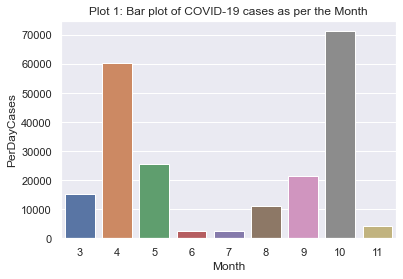

Statistical details of Merged dataset
------------------------------------------
       PerDayCases         Qty       NetWgt      MaxTmp      MinTmp  \
count   995.000000  995.000000   995.000000  995.000000  995.000000   
mean    215.936683    4.468488  4468.487935   15.925126    7.584824   
std     284.582410    1.073946  1073.945560    4.174336    4.168272   
min       0.000000    0.390000   390.000000    6.500000   -3.800000   
25%      18.000000    3.849375  3849.375000   13.000000    4.700000   
50%      87.000000    4.449333  4449.333333   16.100000    7.700000   
75%     311.500000    5.034286  5034.285714   18.800000   10.800000   
max    1283.000000    7.786667  7786.666667   25.700000   15.900000   

             Rain     WindSpd       Month       TotalRef  
count  995.000000  995.000000  995.000000     995.000000  
mean     1.945226    9.256281    6.178894   26312.813065  
std      3.438846    4.498930    2.188813   58472.448919  
min      0.000000    2.800000    3.000000  

In [90]:
# Calling the main function. This is point from where the execution of program starts.
mainExecution()

💡 Insights: 
- Plot 0: This plot shows the number of confirm COVID-19 cases as per the County in Ireland. The size of marker indicates the number of confirm cases. As the number of such instance increases the size of marker also increases. The biggest marker is on Dublin which infers Dublin has the maximum number of COVID-19 cases in Ireland.
- Plot 1: This plot shows the number of confirm COVID-19 cases per month in Ireland. We can see maximum number of cases was in the month of October followed by the month of April. Also, the month of July had least number of COVID-19 cases.
- Plot 2: This plot shows the scatter plot between Wind Speed and COVID-19 cases by different hospital department. This plot shows that there is not much relationship between Wind Speed and COVID-19 cases. 
- Plot 3: This plot also shows the scatter plot between COVID-19 cases and Total referrals done in Hospital. We can infer that there is some positive association between these two variables. We can see Ordinary Least Squares (OLS) regression trendline which shows the line equation and also R-squared value while hovering.
- Plot 4: This plot shows bar plot of the different departments of COVID-19 testing hospital with number of COVID-19 cases. We can deduce that maximum number of cases was from Others department which includes Pregnant Woman, Residential Setting and Prison Inmate. This is followed by General Covid Test department which has two types of Referrals i.e., General Referrals and Covid Testing Referrals. The lowest cases was from individuals who was unable to travel.
- Plot 5: This plot shows bar plot of the different departments of COVID-19 testing hospital with number of COVID-19 cases according to Month. We can say that the maximum number of cases was in the month of October which was of General Covid test and Others hospital department. 
- Plot 6: This plot is the scatter matrix which shows the relationship between different parameters such as Total Referrals, Rain, Net Weight of Garbage collection and sum of COVID-19 cases differentiated by Referral types. We can infer that there is some considerable association between COVID-19 cases and Net Weight of Waste collection and also between COVID-19 cases and Total Referrals. Also, there is not much relationship between COVID-19 cases and Rain.
- Plot 7: From this sunburst plot we can conclude that maximum number of COVID-19 cases was from Others hospital department which includes Pregnant Woman, Residential Setting and Prison Inmate and is part of General Referral. This is followed by General Covid test which comes under Covid Testing Referrals. Moreover, we can also infer that maximum Quantity of waste collection is from Unable to travel Category though minimum number of COVID-19 cases is from this department.
- Plot 8: This tree map gives the overall idea of Hospital departments having maximum number of COVID-19 cases. The different colours show how number of cases varies with respect to Maximum Temperature. We can see that maximum temperature was in the case of General Covid test which is the part of Covid testing referrals having second highest number of Covid cases.
- Plot 9: This box plot shows that the maximum number of COVID-19 cases was in the month of October. Also, the Covid testing referrals was started from the month of May. The least number of cases was in the month of June.
- Plot 10: This density contour plot shows the range of both the referrals types in the first part. The second part also shows the variability of COVID-19 cases with respect to Rain and the third part shows the histogram for the same. We can say that General Referral type has higher variability as compared to Covid testing Referrals whereas Rain does not have much relation with COVID-19 cases.
- Plot 11: This scatter plot shows association between COVID-19 cases and Quantity of Waste Collection with Month. We can infer that maximum number of instances was from Others department and is in the month of October. 